<a href="https://colab.research.google.com/github/chaiwat-api/Sincal_FaultReport/blob/main/gen_fault.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Option: การเชื่อมต่อ MS ACCESS database ด้วย pyodbc library**

In [ ]:
! pip install pyodbc

In [ ]:
import pandas as pd
import pyodbc
conn_str = 'Driver={Microsoft Access Driver (*.mdb, *.accdb)};DBQ=C:\\Users\\chaiw\\Desktop\\coding\\Python\\database.mdb;'
conn = pyodbc.connect(conn_str)

node = pd.read_sql_query('SELECT Node_ID, Group_ID, Variant_ID, Name, Un FROM Node', conn)
net = pd.read_sql_query('SELECT Group_ID, Variant_ID, Name FROM NetworkGroup', conn)
sc1_node = pd.read_sql_query('SELECT Node_ID, Variant_ID, Flag_SC, SR, Ik2, Z1r, Z1i, Z0r, Z0i FROM SC1NodeResult', conn)
sc3_node = pd.read_sql_query('SELECT Node_ID, Variant_ID, Flag_Fault, Sk2, Ik2 FROM SC3NodeResult', conn)

conn.close()

In [ ]:
%%html
<h1><marquee style='width: 50%; color: #FA8072;'><b>Start Here!</b></marquee></h1>

# **1. Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. การนำแปลง MS ACCESS database เป็น CSV**

In [ ]:
# @title **Input Data**
# @markdown ---
work_file_path = "/content/drive/MyDrive/KAIZEN/KAIZEN 2024/Input/" #@param {type:"string"}
# @markdown ---

In [ ]:
# install mdbtool CLI
# https://github.com/mdbtools/mdbtools
!apt-get install mdbtools

# display all folders and files in working directory
%cd {work_file_path}
%ls
# use mdb-export command to select interested tables to store in csv files
!mdb-export database.mdb Node > Node.csv
!mdb-export database.mdb NetworkGroup > NetworkGroup.csv
!mdb-export database.mdb SC3NodeResult > SC3NodeResult.csv
!mdb-export database.mdb SC1NodeResult > SC1NodeResult.csv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmdb3 libmdbsql3
Suggested packages:
  bash-completion
The following NEW packages will be installed:
  libmdb3 libmdbsql3 mdbtools
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 136 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdb3 amd64 1.0.0+dfsg-1 [68.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmdbsql3 amd64 1.0.0+dfsg-1 [18.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mdbtools amd64 1.0.0+dfsg-1 [48.3 kB]
Fetched 136 kB in 0s (450 kB/s)
Selecting previously unselected package libmdb3:amd64.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../libmdb3_1.0.0+dfsg-1_amd64.deb ...
Unpacking libmdb3:amd64 (1.0.0+dfsg-1

In [ ]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
node = pd.read_csv('Node.csv', usecols= ['Node_ID','Group_ID','Variant_ID','Name','Un'], skip_blank_lines=True, encoding='utf8')
net = pd.read_csv('NetworkGroup.csv', usecols= ['Group_ID','Variant_ID','Name'], skip_blank_lines=True, encoding='utf8')
sc3_node = pd.read_csv('SC3NodeResult.csv', usecols= ['Node_ID','Variant_ID','Flag_Fault','Sk2','Ik2'],skip_blank_lines=True, encoding='utf8')
sc1_node = pd.read_csv('SC1NodeResult.csv', usecols= ['Node_ID','Variant_ID','Flag_SC','SR','Ik2','Z1r','Z1i','Z0r','Z0i'],skip_blank_lines=True, encoding='utf8')

# **3. fault table preparation**

In [ ]:
%%time
merged_node_net = pd.merge(node, net, on=['Group_ID','Variant_ID'], how='left')
merged_sc = pd.merge(sc3_node, sc1_node, on=['Node_ID','Variant_ID'], how='left')
init_table = pd.merge(merged_node_net, merged_sc, on='Node_ID', how='left')

df = init_table[['Node_ID','Name_x','Un','Name_y','Ik2_x','Sk2','Ik2_y','SR','Z1r','Z1i','Z0r','Z0i']]
df = df.rename(columns={'Name_x':'Bus','Un':'Voltage [kV]','Name_y':'Area',
                        'Ik2_x':'3 ph-g [kA]','Sk2':'3 ph-g [MVA]',
                        'Ik2_y':'1 ph-g [kA]','SR':'1 ph-g [MVA]','Z1r':'R1 [Ohm]',
                        'Z1i':'X1 [Ohm]','Z0r':'R0 [Ohm]','Z0i':'X0 [Ohm]'})

df.dropna(inplace=True) # ลบ node/bus ที่ไม่มีการเชื่อมต่อออก
df['Bus'] = df['Bus'].str.strip()
df['Area'] = df['Area'].str.strip()
df = df[~df['Bus'].isin([""])]

splited_df = df['Bus'].str.split('_', expand=True).rename(columns={0:'Station', 1:'Location', 2:'Suffix'})
temp_df= df.join(splited_df)
temp_df.drop(columns='Suffix',inplace=True)

excluded_stations = ["rs", "N", "KT1A", "KT2A", "KT3A", "KT4A", "KT5A", "KT6A", "KT7A", "KT8A", "TX1", "TX2", "TX3", "TX4", "TX5"]
bus_df = temp_df[~temp_df['Station'].isin(excluded_stations)]
# display(bus_df)

column_precision_map = {
    "3 ph-g [kA]": 2, "3 ph-g [MVA]": 2,
    "1 ph-g [kA]": 2, "1 ph-g [MVA]": 2,
    "R1 [Ohm]": 5, "X1 [Ohm]": 5,
    "R0 [Ohm]": 5, "X0 [Ohm]": 5
}

for col, dec in column_precision_map.items():
    bus_df[col] = bus_df[col].round(decimals=dec)

selected_columns = [
    'Station', 'Location', 'Area','Voltage [kV]', '3 ph-g [kA]', '3 ph-g [MVA]',
    '1 ph-g [kA]', '1 ph-g [MVA]', 'R1 [Ohm]', 'X1 [Ohm]', 'R0 [Ohm]', 'X0 [Ohm]'
]

report_df = bus_df[selected_columns].sort_values(by=['Station','Location','Voltage [kV]']).reset_index(drop=True)
# First, we initialize the 'IC [kA]' column to avoid chained assignment warnings
report_df['IC [kA]'] = pd.NA

# Apply conditions and set 'IC [kA]' for special_bus and network_bus conditions directly in the original DataFrame
report_df.loc[(report_df['Station'] == "BZ") & (report_df['Voltage [kV]'] == 69), 'IC [kA]'] = 31.5
report_df.loc[report_df['Station'].isin(["BR", "NLG", "SD", "WL"]) & (report_df['Voltage [kV]'] == 12), 'IC [kA]'] = 31.5
report_df.loc[report_df['Station'].isin(["BR", "NLG", "SD", "WL"]) & (report_df['Voltage [kV]'] == 69), 'IC [kA]'] = 40

# Filter out rows that need modification without creating separate DataFrames
unnorm_idx = report_df[(report_df['Station'].isin(["BZ", "BR", "NLG", "SD", "WL"])) & (report_df['Voltage [kV]'].isin([69, 12]))].index

# Dropping rows directly from report_df instead of creating a modified copy
remain_record_df = report_df.drop(unnorm_idx)

# Directly map 'Voltage [kV]' values to 'IC [kA]' values for modMEA_df
voltage_ic_map = {230: 50, 115: 31.5, 69: 40, 24: 25, 12: 25}
remain_record_df['IC [kA]'] = remain_record_df['Voltage [kV]'].map(voltage_ic_map)

# Revise IC for 115kV MEA's customer to be 25 kA
remain_record_df.loc[(remain_record_df['Area'] == "CUS") & (report_df['Voltage [kV]'] == 115), 'IC [kA]'] = 25

# Since modMEA_df already excludes the special and network buses, we can directly concat with original report_df for the missing rows
final_df = pd.concat([remain_record_df, report_df.loc[unnorm_idx]])

# Sort, reset index, and select columns in one step
fault_table = final_df.sort_values(by=['Voltage [kV]', 'Area', 'Station'], ascending=False).reset_index(drop=True)[
    ['Voltage [kV]', 'Area', 'Station', 'Location', '3 ph-g [kA]', '3 ph-g [MVA]',
     '1 ph-g [kA]', '1 ph-g [MVA]', 'IC [kA]', 'R1 [Ohm]', 'X1 [Ohm]', 'R0 [Ohm]', 'X0 [Ohm]']]
# fault_table

CPU times: user 71.7 ms, sys: 2.36 ms, total: 74.1 ms
Wall time: 114 ms


# **4. Save ข้อมูล Fault_table Dataframe ไว้ใน Excel sheet**

In [ ]:
# @title **Input Data**
# @markdown ---
output_file_path = "/content/drive/MyDrive/KAIZEN/KAIZEN 2024/output/monthly_fault_report.xlsx" #@param {type:"string"}
date_input = '2024-04-15' # @param {type:"date"}
# @markdown ---

In [ ]:
# Create sheet name from date_input string variable
year_month = date_input[:7]

# Add calculated time column
fault_table['Calculated_date'] = date_input
display(fault_table)

# Append DataFrame to existing excel file
with pd.ExcelWriter(
    output_file_path,
    mode='a'
) as writer:
    fault_table.to_excel(writer, sheet_name=year_month, index=False)

print("File written Successfully")

,Voltage [kV],Area,Station,Location,3 ph-g [kA],3 ph-g [MVA],1 ph-g [kA],1 ph-g [MVA],IC [kA],R1 [Ohm],X1 [Ohm],R0 [Ohm],X0 [Ohm],Calculated_date
0,230,MEA230,VDT,230,37.47,14926.00,31.88,4233.17,50.0,0.42170,3.51897,2.51762,4.99814,2024-04-15
1,230,MEA230,TTT,230,32.34,12884.09,21.22,2817.92,50.0,0.33735,4.09196,1.40048,10.47373,2024-04-15
2,230,MEA230,KDT,230,14.50,5776.55,13.06,1734.48,50.0,0.75250,9.12675,1.02715,12.14021,2024-04-15
3,230,MEA230,CLT,230,37.93,15110.34,31.00,4116.27,50.0,0.20125,3.49513,1.28715,5.74962,2024-04-15
4,230,MEA230,BET,230,40.08,15968.28,34.44,4573.07,50.0,0.15900,3.30900,0.53383,4.91831,2024-04-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,12,MEA69,BC,20,11.46,238.20,12.72,88.10,25.0,0.02103,0.60417,0.00529,0.42544,2024-04-15
933,12,MEA115,SWG,10,12.57,261.24,13.60,94.25,25.0,0.00863,0.55115,0.00529,0.42544,2024-04-15
934,12,MEA115,SWG,20,12.57,261.24,13.60,94.25,25.0,0.00863,0.55115,0.00529,0.42544,2024-04-15
935,12,MEA115,SAM,10,12.65,263.01,13.67,94.71,25.0,0.00796,0.54744,0.00529,0.42544,2024-04-15


File written Successfully


# **5. สร้างตารางหาค่า fault สูงสุดทั้งแบบ 3ph-g และ 1ph-g ของแต่ละ Network Area**

In [ ]:
%%time
# Group by 'Voltage [kV]' and 'Area', and find the indices of the max values in '3 ph-g [kA]' and '1 ph-g [kA]'
idx_max_3ph = fault_table.groupby(['Voltage [kV]', 'Area'], as_index=False)['3 ph-g [kA]'].idxmax()
idx_max_1ph = fault_table.groupby(['Voltage [kV]', 'Area'], as_index=False)['1 ph-g [kA]'].idxmax()

# Extract the relevant rows for '3 ph-g [kA]' and '1 ph-g [kA]' max values
max_3ph_df = fault_table.iloc[idx_max_3ph['3 ph-g [kA]'], [0,1,2,4,8]].reset_index(drop=True)
max_1ph_df = fault_table.iloc[idx_max_1ph['1 ph-g [kA]'], [0,1,2,6,8]].reset_index(drop=True)

# Merge the two sets of rows on 'Voltage [kV]' and 'Area' to create the final DataFrame
final_report_df = pd.merge(max_3ph_df, max_1ph_df, on=['Voltage [kV]', 'Area'], how='outer')
final_report_df = final_report_df.rename(columns={'Station_x':'Max_3ph_Station','IC [kA]_x':'Max_3ph_Station IC [kA]',
                                                  'Station_y':'Max_1ph_Station','IC [kA]_y':'Max_1ph_Station IC [kA]'
                                                  }).sort_values(by=['Voltage [kV]'], ascending=False)

# filter out the 24 kV customer row and the SPP row.
filtered_df = final_report_df.loc[~((final_report_df['Area'] == 'CUS') & (final_report_df['Voltage [kV]'] == 24))]
filtered_data = filtered_df[~filtered_df['Area'].isin(['SPP'])]

# Define the mapping based on the task description
mapping_dict = {
    "EGAT230": "230 kV EGAT's network",
    "MEA230": "230 kV network",
    "MEA115": "115 kV network",
    "MEA69": "69 kV network",
    "CUS": "Customer"
}

# Apply the mapping to the 'Area' column
filtered_data['Area'] = filtered_data['Area'].map(lambda x: mapping_dict.get(x, x))
filtered_data.reset_index(drop=True, inplace=True)

# Reindex DataFrame for visualization
indx = pd.Index([4,2,9,8,7,6,5,3,1,0])
filtered_data = filtered_data.reindex(indx)

# Export filtered_data to be for_plot.csv
out_uri = '/content/drive/MyDrive/KAIZEN/KAIZEN 2024/output/for_plot.csv'
filtered_data.to_csv(out_uri, index=False)
filtered_data

CPU times: user 27.7 ms, sys: 0 ns, total: 27.7 ms
Wall time: 52 ms


,Voltage [kV],Area,Max_3ph_Station,3 ph-g [kA],Max_3ph_Station IC [kA],Max_1ph_Station,1 ph-g [kA],Max_1ph_Station IC [kA]
4,69,Customer,MBGC,27.36,40.0,MBGC,18.43,40.0
2,115,Customer,CTJC,16.48,25.0,RLRC2,14.87,25.0
9,12,69 kV network,BR,20.84,31.5,BR,23.69,31.5
8,12,115 kV network,PM,12.67,25.0,PM,13.68,25.0
7,24,69 kV network,BP,7.18,25.0,CK,7.48,25.0
6,24,115 kV network,BRG,8.82,25.0,LSI,7.69,25.0
5,69,69 kV network,BPT,35.81,40.0,BPT,33.61,40.0
3,115,115 kV network,BPT,22.04,31.5,BPT,20.43,31.5
1,230,230 kV network,BET,40.08,50.0,BET,34.44,50.0
0,230,230 kV EGAT's network,ON,49.98,50.0,SB,46.05,50.0


# **6. นำค่าใน filtered_data แสดงผลเป็นกราฟเทียบ 3ph-g และ 1 ph-g ของแต่ละพื้นที่**

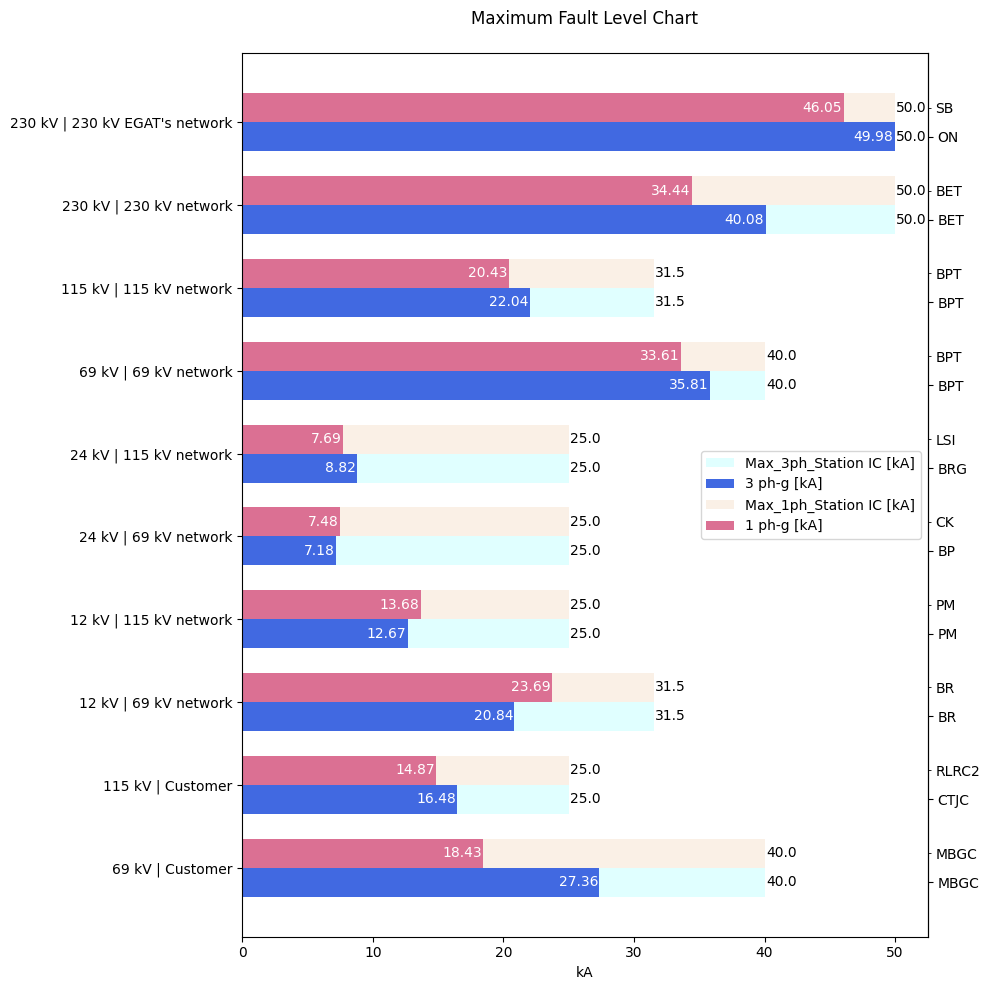

CPU times: user 896 ms, sys: 282 ms, total: 1.18 s
Wall time: 921 ms


In [ ]:
%%time
import matplotlib.pyplot as plt
import numpy as np

# Create a new column 'label' by concatenating 'Voltage [kV]' and 'Area' with ' kV |' in between
filtered_data['label'] = filtered_data['Voltage [kV]'].astype(str) + ' kV | ' + filtered_data['Area']

# Number of bars
index = range(len(filtered_data))

# Bar width
bar_width = 0.35

# Create a horizontal bar chart including background bars for interrupting capacities and add data labels
fig, ax = plt.subplots(figsize=(10, 10))

# Horizontal background bars for 'Max_3ph_Station IC [kA]'
background_bars1 = ax.barh(index, filtered_data['Max_3ph_Station IC [kA]'], bar_width, label='Max_3ph_Station IC [kA]', color='lightcyan')
# Add data labels for 'Max_3ph_Station IC [kA]' on the right
for rect in background_bars1:
    width = rect.get_width()
    ax.text(width + 0.1, rect.get_y() + rect.get_height() / 2., f'{width:.1f}', ha='left', va='center')

# Horizontal bars for '3 ph-g [kA]'
bars1 = ax.barh(index, filtered_data['3 ph-g [kA]'], bar_width, label='3 ph-g [kA]', color='royalblue')
# Add data labels for '3 ph-g [kA]' on the left
for rect in bars1:
    width = rect.get_width()
    ax.text(width - 0.1, rect.get_y() + rect.get_height() / 2., f'{width:.2f}', ha='right', va='center', color='white')

# Horizontal background bars for 'Max_1ph_Station IC [kA]', offset by bar width for alignment
background_bars2 = ax.barh([p + bar_width for p in index], filtered_data['Max_1ph_Station IC [kA]'], bar_width, label='Max_1ph_Station IC [kA]', color='linen')
# Add data labels for 'Max_1ph_Station IC [kA]' on the right
for rect in background_bars2:
    width = rect.get_width()
    ax.text(width + 0.1, rect.get_y() + rect.get_height() / 2., f'{width:.1f}', ha='left', va='center')

# Horizontal bars for '1 ph-g [kA]', offset by bar width
bars2 = ax.barh([p + bar_width for p in index], filtered_data['1 ph-g [kA]'], bar_width, label='1 ph-g [kA]', color='palevioletred')
# Add data labels for '1 ph-g [kA]' on the left
for rect in bars2:
    width = rect.get_width()
    ax.text(width - 0.1, rect.get_y() + rect.get_height() / 2., f'{width:.2f}', ha='right', va='center', color='white')

# Labels, title and legend
ax.set_xlabel('kA')
ax.set_title('Maximum Fault Level Chart\n')
ax.set_yticks([p + bar_width/2 for p in index])  # Adjust yticks to center between bars
ax.set_yticklabels(filtered_data['label'])

# Creating a second y-axis for station names
ax2 = ax.secondary_yaxis('right')
ax2.set_yticks([p for p in index])  # Set ticks for '3 ph-g [kA]'
ax2.set_yticklabels(filtered_data['Max_3ph_Station'])
ax2.set_yticks([p + bar_width for p in index], minor=True)  # Set minor ticks for '1 ph-g [kA]'
ax2.set_yticklabels(filtered_data['Max_1ph_Station'], minor=True)

# Legend configuration
ax.legend()

# Layout adjustment
plt.tight_layout()

# Show the plot
plt.show()